In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_state = 42
batch_size = 16
num_epochs = 200

learining_rate = 0.001
table_name = 'air_quality.csv'
target = 'air_quality'

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(random_state)

In [4]:
data = pd.read_csv(table_name)

In [5]:
data.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,air_quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,1
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,1
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,1
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,1
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   air_quality                    5000 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 390.8 KB


In [7]:
data.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,air_quality
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800,0.700000
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084,0.458303
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000,0.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000,0.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000,1.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000,1.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000,1.000000


In [8]:
X = data.drop(target, axis=1).values
y = data[target].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=random_state
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val,
    test_size=0.5,
    stratify=y_val,
    random_state=random_state
)

In [9]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
class AirQualityDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
train_dataset = AirQualityDataset(X_train, y_train)
val_dataset = AirQualityDataset(X_val, y_val)
test_dataset = AirQualityDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class AirQualityModel(nn.Module):
    def __init__(self, input_dim, dropout_p=0.5):
        """
        Initializes the AirQualityModel with 5 linear layers and Dropout.

        Parameters:
        - input_dim (int): Number of input features.
        - dropout_p (float): Probability of an element to be zeroed. Default: 0.5
        """
        super(AirQualityModel, self).__init__()
        
        # Define the first linear layer (Input Layer)
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_p)
        
        # Define the second linear layer (Hidden Layer 1)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_p)
        
        # Define the third linear layer (Hidden Layer 2)
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_p)
        
        # Define the fourth linear layer (Hidden Layer 3)
        self.fc4 = nn.Linear(32, 16)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=dropout_p)
        
        # Define the fifth linear layer (Output Layer)
        self.fc5 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        """
        Defines the forward pass of the network.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after passing through the network.
        """
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        
        x = self.fc5(x)
        x = self.sigmoid(x)
        
        return x

In [13]:
input_dim = X_train.shape[1]
model = AirQualityModel(input_dim=input_dim).to(device)

In [14]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learining_rate)


In [15]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
    
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}')

Epoch 1/200 - Train Loss: 0.3975 - Val Loss: 0.1458
Epoch 2/200 - Train Loss: 0.2059 - Val Loss: 0.1021
Epoch 3/200 - Train Loss: 0.1300 - Val Loss: 0.0908
Epoch 4/200 - Train Loss: 0.1189 - Val Loss: 0.0895
Epoch 5/200 - Train Loss: 0.1282 - Val Loss: 0.0816
Epoch 6/200 - Train Loss: 0.1167 - Val Loss: 0.0820
Epoch 7/200 - Train Loss: 0.0988 - Val Loss: 0.0857
Epoch 8/200 - Train Loss: 0.1040 - Val Loss: 0.0804
Epoch 9/200 - Train Loss: 0.0994 - Val Loss: 0.0793
Epoch 10/200 - Train Loss: 0.1054 - Val Loss: 0.0772
Epoch 11/200 - Train Loss: 0.0938 - Val Loss: 0.0759
Epoch 12/200 - Train Loss: 0.0919 - Val Loss: 0.0772
Epoch 13/200 - Train Loss: 0.0801 - Val Loss: 0.0834
Epoch 14/200 - Train Loss: 0.0865 - Val Loss: 0.0794
Epoch 15/200 - Train Loss: 0.0863 - Val Loss: 0.0824
Epoch 16/200 - Train Loss: 0.0783 - Val Loss: 0.0819
Epoch 17/200 - Train Loss: 0.0811 - Val Loss: 0.0774
Epoch 18/200 - Train Loss: 0.1096 - Val Loss: 0.0836
Epoch 19/200 - Train Loss: 0.0735 - Val Loss: 0.0742
Ep

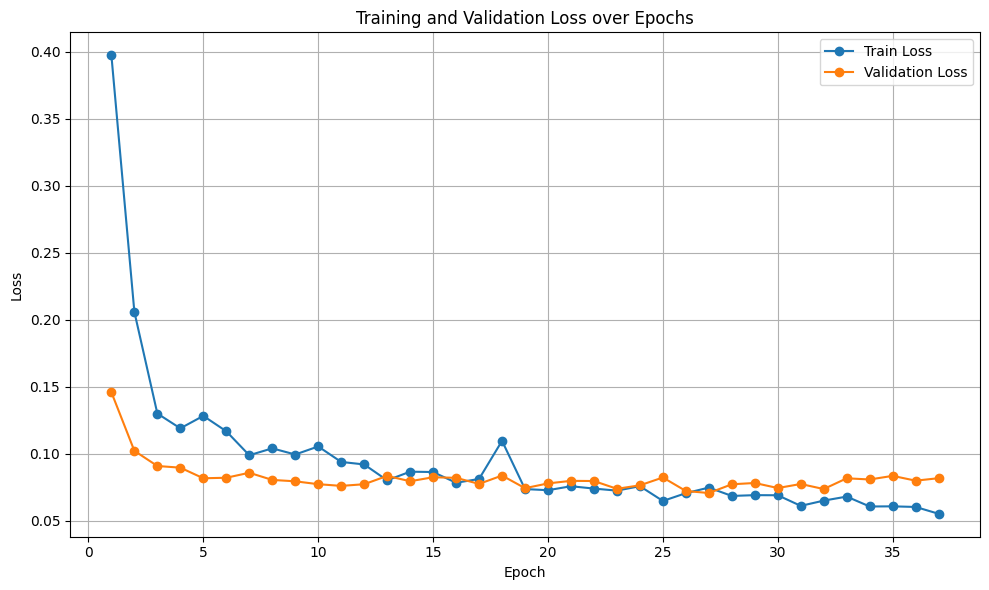

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
model.load_state_dict(best_model_state)
model.eval()

all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        outputs = model(X_batch)
        probs = outputs.cpu().numpy().flatten()
        
        preds = (probs >= 0.5).astype(int)
        
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu().numpy().flatten())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

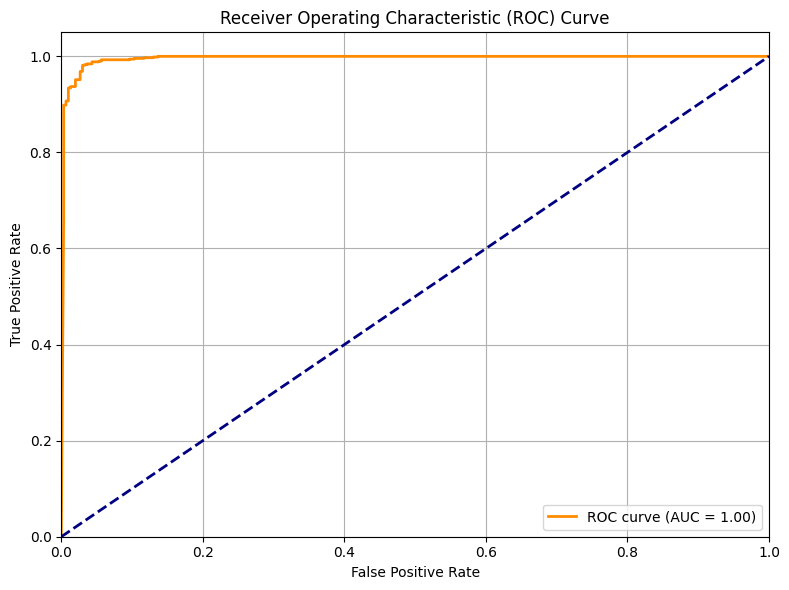

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       300
         1.0       0.97      0.99      0.98       700

    accuracy                           0.98      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.98      0.98      1000

